In [ ]:
!pip install pyproj==1.9.6

In [4]:
!pip install h5netcdf

In [3]:
import pyproj
import s3fs
import xarray as xr
import numpy as np

# Import dataset

In [33]:
fs_s3 = s3fs.S3FileSystem(anon=True, client_kwargs={
         'endpoint_url': 'https://s3.eu-de.cloud-object-storage.appdomain.cloud'
      })
s3path = 'greenlytics-public/MetNo_MEPS_example.nc'
remote_file_obj = fs_s3.open(s3path, mode='rb')
ds = xr.open_dataset(remote_file_obj, engine='h5netcdf')

<xarray.Dataset>
Dimensions:                                                   (height0: 1, height1: 1, height2: 2, height7: 1, height_above_msl: 1, valid_time: 67, x: 949, y: 1069)
Coordinates:
  * height0                                                   (height0) float32 0.0
  * height1                                                   (height1) float32 2.0
  * height2                                                   (height2) float32 80.0 120.0
  * height7                                                   (height7) float32 10.0
  * height_above_msl                                          (height_above_msl) float32 0.0
    latitude                                                  (y, x) float64 ...
    longitude                                                 (y, x) float64 ...
    reference_time                                            datetime64[ns] ...
  * valid_time                                                (valid_time) int64 0 ... 66
  * x                              

# Create projection
## This dataset uses a Lambert Conformal Conic projection 
## https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection

In [42]:
p = pyproj.Proj('+proj=lcc +lat_0=63.3 +lon_0=15 +lat_1=63.3 +lat_2=63.3 +no_defs +R=6.371e+06')

# Reverse-compute the latitudes and longitudes from x and y

In [43]:
x_list = np.array(ds.x.values.tolist() * len(ds.y.values))
y_list = np.array([[v] * len(ds.x.values) for v in ds.y.values]).flatten()
proj_longitudes, proj_latitudes = p(x_list, y_list, inverse=True)
proj_longitudes = np.reshape(proj_longitudes, (ds.y.shape[0], ds.x.shape[0]))
proj_latitudes = np.reshape(proj_latitudes, (ds.y.shape[0], ds.x.shape[0]))

# Make sure computed coordinates correspond to metadata

In [44]:
difference = np.absolute(ds.latitude.values - proj_latitudes)
print("Maximum difference between metadata latitudes" + 
      "and the ones computed from (x,y) values: {0}".format(np.max(difference)))
print(difference)

Maximum difference between metadata latitudesand the ones computed from (x,y) values: 5.684341886080802e-14
[[4.97379915e-14 2.84217094e-14 2.13162821e-14 ... 2.84217094e-14
  2.13162821e-14 2.84217094e-14]
 [2.84217094e-14 2.84217094e-14 2.13162821e-14 ... 2.84217094e-14
  2.13162821e-14 2.84217094e-14]
 [2.84217094e-14 2.84217094e-14 4.97379915e-14 ... 2.84217094e-14
  2.13162821e-14 0.00000000e+00]
 ...
 [0.00000000e+00 2.84217094e-14 2.84217094e-14 ... 1.42108547e-14
  2.84217094e-14 2.84217094e-14]
 [1.42108547e-14 2.84217094e-14 0.00000000e+00 ... 0.00000000e+00
  2.84217094e-14 0.00000000e+00]
 [2.84217094e-14 0.00000000e+00 2.84217094e-14 ... 2.84217094e-14
  1.42108547e-14 0.00000000e+00]]


In [45]:
difference = np.absolute(ds.longitude.values - proj_longitudes)
print("Maximum difference between metadata longitudes" + 
      "and the ones computed from (x,y) values: {0}".format(np.max(difference)))
print(difference)

Maximum difference between metadata longitudesand the ones computed from (x,y) values: 3.552713678800501e-14
[[3.16413562e-15 0.00000000e+00 3.16413562e-15 ... 7.10542736e-15
  7.10542736e-15 1.42108547e-14]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 7.10542736e-15
  7.10542736e-15 7.10542736e-15]
 [0.00000000e+00 3.21964677e-15 0.00000000e+00 ... 7.10542736e-15
  0.00000000e+00 7.10542736e-15]
 ...
 [1.77635684e-14 1.42108547e-14 1.42108547e-14 ... 2.13162821e-14
  1.42108547e-14 2.13162821e-14]
 [3.55271368e-15 1.42108547e-14 1.42108547e-14 ... 2.84217094e-14
  1.42108547e-14 2.13162821e-14]
 [1.77635684e-14 1.42108547e-14 1.06581410e-14 ... 1.42108547e-14
  2.13162821e-14 2.13162821e-14]]


In [48]:
print("Southernmost computed latitude: {0}".format(np.min(proj_latitudes)))
print("Southernmost metadata latitude: {0}".format(np.min(ds.latitude.values)))
print("Northernmost computed latitude: {0}".format(np.max(proj_latitudes)))
print("Northernmost metadata latitude: {0}".format(np.max(ds.latitude.values)))
print("Westernmost computed longitude: {0}".format(np.min(proj_longitudes)))
print("Westernmost metadata longitude: {0}".format(np.min(ds.longitude.values)))
print("Easternmost computed longitude: {0}".format(np.max(proj_longitudes)))
print("Easternmost metadata longitude: {0}".format(np.max(ds.longitude.values)))

Southernmost computed latitude: 49.765385397300186
Southernmost metadata latitude: 49.765385397300214
Northernmost computed latitude: 75.22869642408492
Northernmost metadata latitude: 75.22869642408492
Westernmost computed longitude: -18.122414266774282
Westernmost metadata longitude: -18.1224142667743
Easternmost computed longitude: 54.24126162807411
Easternmost metadata longitude: 54.241261628074135


# Plot a map of the area covered by the dataset

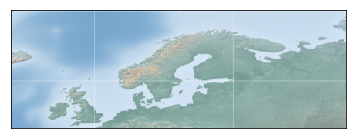

In [54]:
from itertools import chain
from mpl_toolkits.basemap import Basemap

def draw_map(m, scale=1):
    # draw a shaded-relief image
    m.shadedrelief(scale=scale)
    
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')
        
m = Basemap(llcrnrlon=np.min(ds.longitude.values),
            llcrnrlat=np.min(ds.latitude.values),
            urcrnrlon=np.max(ds.longitude.values),
            urcrnrlat=np.max(ds.latitude.values), 
            resolution='i', 
            projection='cyl', 
            lon_0=15, 
            lat_0=63)

draw_map(m)